<a href="https://colab.research.google.com/github/esharma3/Time-Series-Analysis/blob/master/07_Time_Series_Modeling_using_Facebook_Prophet_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Modeling using Facebook Prophet - UNIVARIATE Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
import plotly.express as px

plt.rcParams["figure.figsize"] = (10, 8)
plt.rcParams["axes.grid"] = False



In [2]:
# hourly data, only a asubset has been taken here

df = pd.read_csv(
    "https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/nyc_energy_consumption.csv"
)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeStamp  49205 non-null  object 
 1   demand     49124 non-null  float64
 2   precip     48975 non-null  float64
 3   temp       49019 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [4]:
df["timeStamp"] = pd.to_datetime(df["timeStamp"])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [6]:
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [7]:
ny_df = df.set_index("timeStamp")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd885cb828>,
      dtype=object)

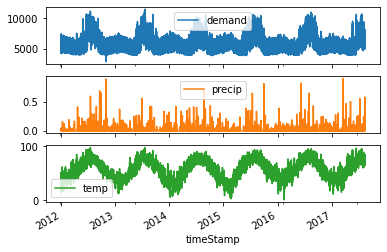

In [8]:
ny_df.plot(subplots=True)

In [9]:
# resampling the data from hourly to daily level

ny_df.resample("D").mean()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500
...,...,...,...
2017-08-08,6471.626042,0.000000,71.039167
2017-08-09,6811.112167,0.047529,73.852500
2017-08-10,5582.297000,0.002033,75.217500


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fcd8817b048>,
      dtype=object)

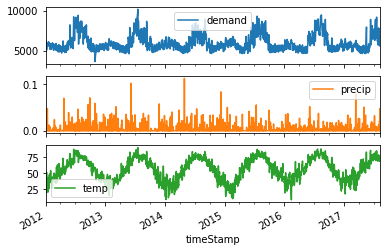

In [10]:
# plotting the resampled data

ny_df.resample("D").mean().plot(subplots=True)

In [11]:
ny_df_daily = ny_df.resample("D").mean()

In [12]:
ny_df_daily.head()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500


## Prophet Paper - https://peerj.com/preprints/3190/

y(t)= g(t) + s(t) + h(t) + εt

g(t) - model trend (model non periodic changes in the value of the time series). Trend component can be piecewise linear regression model which is default model or it can be logistic growth curve model. FB Prophet automatically detects the changes in trend by automatically detecting the change points and this change ponits come with the piecewise linear regression model that runs internally. 

s(t) - seasonality component is basically the periodic functions that take into account like monthly, weekly etc. In or example it is yearly. By deafult, FB model uses additive seasonality. But sometimes there is a particular growing trend in the dataset (not in our dataset), and a multiplicative modelling is needed.

h(t) - this is for holiday. Sometimes retail sales may spike up during holidays or during the weekend. We can give explicit dates to the model to dictate some trend change and behavior.

εt - residual. This is the error component of the model and it is assumed to be always normally distributed.


### pipenv install fbprophet

In [13]:
from fbprophet import Prophet

The input to the FB model is always a dataframe with 2 columns - first is the timeStamp column that FB requires to be named as "ds" and second is the target column that FB requires to be named as "y".

In [14]:
ny_df_final = ny_df_daily.reset_index()[["timeStamp", "demand"]].rename(
    {"timeStamp": "ds", "demand": "y"}, axis="columns"
)

In [15]:
ny_df_final.head()

,ds,y
0,2012-01-01,4954.833333
1,2012-01-02,5302.954167
2,2012-01-03,6095.512500
3,2012-01-04,6336.266667
4,2012-01-05,6130.245833


In [16]:
# setting up train and test data

train = ny_df_final[
    (ny_df_final["ds"] >= "2012-01-01") & (ny_df_final["ds"] <= "2017-04-30")
]

test = ny_df_final[(ny_df_final["ds"] > "2017-04-30")]

In [17]:
train.shape

(1947, 2)

In [18]:
test.shape

(104, 2)

In [19]:
test

,ds,y
1947,2017-05-01,5417.231583
1948,2017-05-02,5697.950042
1949,2017-05-03,5354.628500
1950,2017-05-04,5235.704833
1951,2017-05-05,5358.639500
...,...,...
2046,2017-08-08,6471.626042
2047,2017-08-09,6811.112167
2048,2017-08-10,5582.297000
2049,2017-08-11,NaN


In [20]:
# we can create the model without passing any parameter but we passed CI = 95% because by default FB model has 80% CI. 
# since our data has seasonality, we have set up yearly_seasonality to True.

m = Prophet(interval_width=0.95, yearly_seasonality=True)

In [21]:
m.fit(train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
# model learned parameters (like coefficients)

m.params

OrderedDict([('k', array([[0.08888412]])),
             ('m', array([[0.59346583]])),
             ('delta',
              array([[ 3.14928730e-08,  1.53741876e-07, -1.03044704e-01,
                      -2.11602996e-08,  1.40085597e-07,  1.81802026e-07,
                       1.43803423e-08, -6.11555343e-07,  6.49671582e-08,
                      -2.60011367e-07, -2.43433220e-02, -7.64404754e-02,
                      -2.03269748e-05, -1.67752062e-07,  2.37209776e-01,
                       3.72434388e-07, -1.02857630e-06, -8.82474336e-02,
                      -3.95645665e-02, -1.56344720e-08,  5.48404650e-08,
                       6.61535467e-08,  4.33979100e-03,  2.60526989e-03,
                       1.24238337e-07]])),
             ('sigma_obs', array([[0.04607601]])),
             ('beta',
              array([[-0.03458253, -0.07052008,  0.05760233,  0.04705168, -0.01407221,
                      -0.00500214, -0.00386595, -0.00073581,  0.00241974, -0.00755868,
                 

In [23]:
future = m.make_future_dataframe(periods=104)
future.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [24]:
forecast = m.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()      # lower and upper is 95% CI level

,ds,yhat,yhat_lower,yhat_upper
2046,2017-08-08,7585.146506,6698.611472,8442.957350
2047,2017-08-09,7574.252310,6699.902154,8482.211186
2048,2017-08-10,7528.960519,6619.797597,8461.675029
2049,2017-08-11,7484.169113,6575.117808,8358.863694
2050,2017-08-12,6909.341600,6022.110309,7779.343837


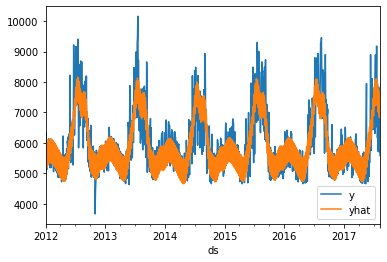

In [25]:
pd.concat([ny_df_final.set_index("ds")["y"], forecast.set_index("ds")["yhat"]], axis=1).plot()

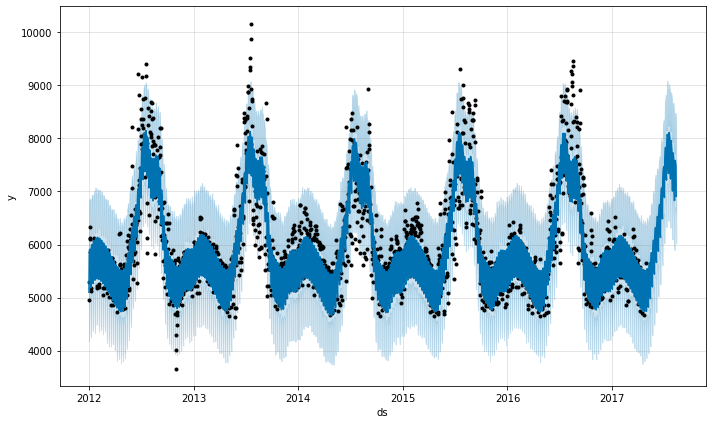

In [26]:
# plotting with the confidence interval (in light blue color). Black points are the actual data points below.

fig1 = m.plot(forecast)

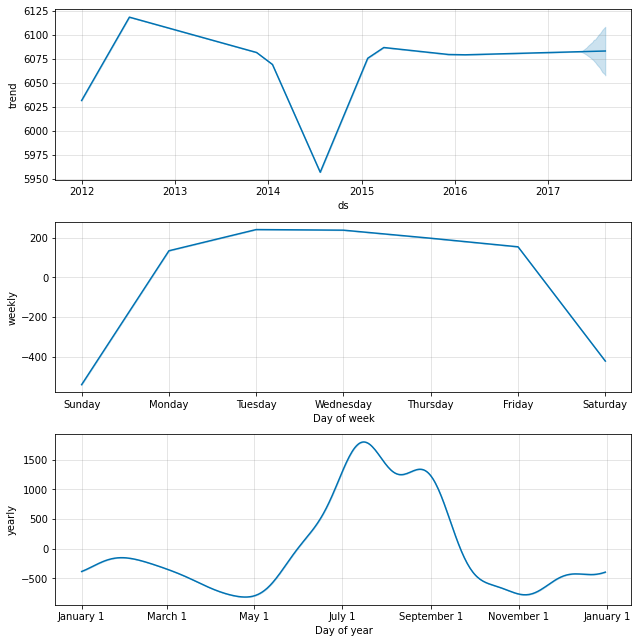

In [27]:
# decomposing various components like yearly, weekly, daily trends
# in the first plot, each point(high or low spike) presents a change point and you can match it with the change point plot in the next cell.

fig2 = m.plot_components(forecast)

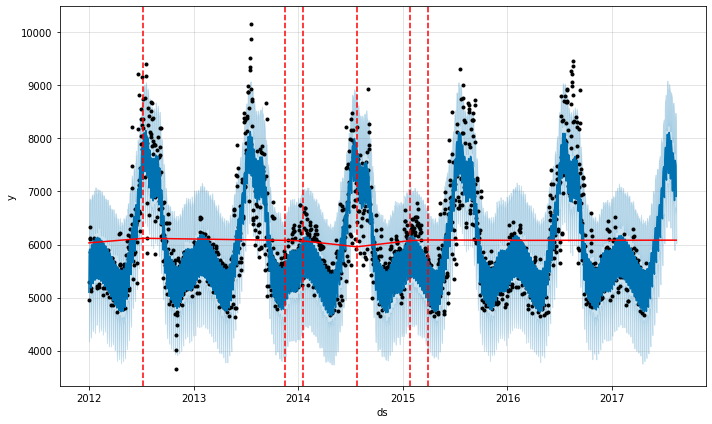

In [28]:
# adding change points to the predictions/data
# fbprophet finds change points only for 80% of the data by default
# we can also add CUSTOM DATA POINTS if we know that our business is impacted by some data points 

from fbprophet.plot import add_changepoints_to_plot

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [29]:
deltas = m.params["delta"].mean(0)
deltas

array([ 3.14928730e-08,  1.53741876e-07, -1.03044704e-01, -2.11602996e-08,
        1.40085597e-07,  1.81802026e-07,  1.43803423e-08, -6.11555343e-07,
        6.49671582e-08, -2.60011367e-07, -2.43433220e-02, -7.64404754e-02,
       -2.03269748e-05, -1.67752062e-07,  2.37209776e-01,  3.72434388e-07,
       -1.02857630e-06, -8.82474336e-02, -3.95645665e-02, -1.56344720e-08,
        5.48404650e-08,  6.61535467e-08,  4.33979100e-03,  2.60526989e-03,
        1.24238337e-07])

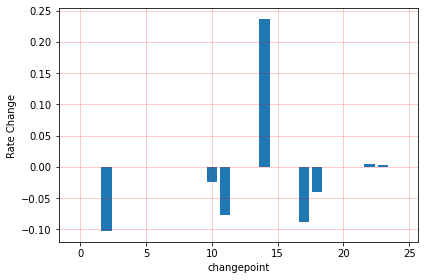

In [30]:
# plotting positive and negative change ponits (it plots up to 25 change points)

fig = plt.figure(facecolor="w")
ax = fig.add_subplot(111)
ax.bar(range(len(deltas)), deltas)
ax.grid(True, which="major", c="red", ls="-", lw=1, alpha=0.2)
ax.set_ylabel("Rate Change")
ax.set_xlabel("changepoint")
fig.tight_layout()

In [31]:
m.changepoints

62     2012-03-03
124    2012-05-04
187    2012-07-06
249    2012-09-06
311    2012-11-07
373    2013-01-08
436    2013-03-12
498    2013-05-13
560    2013-07-14
622    2013-09-14
685    2013-11-16
747    2014-01-17
809    2014-03-20
871    2014-05-21
934    2014-07-23
996    2014-09-23
1058   2014-11-24
1120   2015-01-25
1183   2015-03-29
1245   2015-05-30
1307   2015-07-31
1369   2015-10-01
1432   2015-12-03
1494   2016-02-03
1556   2016-04-05
Name: ds, dtype: datetime64[ns]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


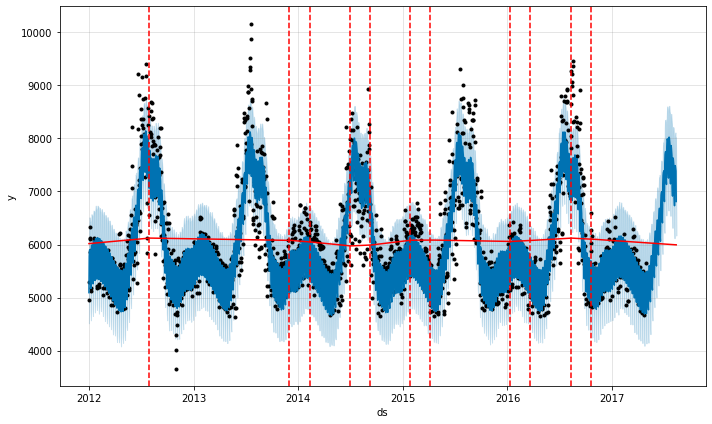

In [32]:
# change change points to 90% from default 80%

pro_change= Prophet(changepoint_range = 0.9, yearly_seasonality=True)
forecast = pro_change.fit(train).predict(future)
fig= pro_change.plot(forecast);
a = add_changepoints_to_plot(fig.gca(), pro_change, forecast)

In [33]:
# using plotly for each visualization

from fbprophet.plot import plot_plotly
import plotly.offline as py

fig = plot_plotly(m, forecast)  # This returns a plotly Figure
py.iplot(fig)

In [34]:
# evaluating our model
# we can also write our own evaluation function
# below we are passing initial 731 days of data
# we are telling our cross validation model to use initial 731 days of data and give predictions on 365 days 

from fbprophet.diagnostics import cross_validation
cv_results = cross_validation( model = m, initial = '731 days', horizon = '365 days')

INFO:fbprophet:Making 5 forecasts with cutoffs between 2014-05-01 00:00:00 and 2016-04-30 00:00:00


In [35]:
cv_results.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-02,5560.399158,4755.124261,6402.596948,5460.325000,2014-05-01
1,2014-05-03,4970.368653,4070.273756,5814.765369,4893.683333,2014-05-01
2,2014-05-04,4846.526492,4016.452261,5728.857559,4764.137500,2014-05-01
3,2014-05-05,5527.405000,4662.228019,6387.180333,5406.762500,2014-05-01
4,2014-05-06,5622.303858,4840.026079,6478.624706,5409.750000,2014-05-01


In [36]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(cv_results)
df_p

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days 12:00:00,251429.065746,501.427029,405.741907,0.072931,0.065579,0.884615
1,37 days 00:00:00,258154.308609,508.088879,413.132705,0.074218,0.066087,0.879121
2,37 days 12:00:00,260458.355734,510.351208,416.504551,0.074798,0.066775,0.879121
3,38 days 00:00:00,263245.456254,513.074513,419.608202,0.075062,0.067182,0.879121
4,38 days 12:00:00,266934.102525,516.656658,424.824052,0.075894,0.067543,0.879121
...,...,...,...,...,...,...,...
653,363 days 00:00:00,260005.135786,509.906987,446.400124,0.082383,0.081701,0.983516
654,363 days 12:00:00,261690.499217,511.556936,447.442090,0.082567,0.082034,0.983516
655,364 days 00:00:00,266012.437438,515.763936,450.969835,0.083405,0.082787,0.978022
656,364 days 12:00:00,266053.564909,515.803805,450.639292,0.083380,0.082787,0.978022


In [37]:
# FB does not provide a lot of hyperparameters to change but there are few and we can change those to improve model performance